# How to model the charging duration (or parking duration) for e-cars at supermarkets?
According to **EHI-WHITEPAPER Elektromobilität im Handel 2023** the average charging times are
| Duration  | Percentage    |
| ---       | ---           | 
| max. 30 mins. | 15%       |
| 30-60mins.    | 50%       | 
| 60-120mins.   | 31%       |
| <120mins.     | 4%        |

Based on these figures we can create some sample data to work with:

Assumption 1: we take the midpoint per interval for our samples, e.g. we use 90mins for the interval from 60-120mins.

Assumption 2: max. parking duration is 5 hours (--> midpoint = 210min)

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

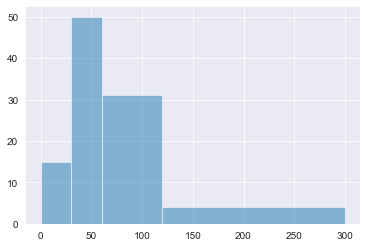

In [2]:
# 100 sample values following the distribution above
parking_duration_sample=[ \
    15, 15, 15, 15, 15, 15, 15, 15, 15, 15, \
    15, 15, 15, 15, 15, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 90, 90, 90, 90, 90, \
    90, 90, 90, 90, 90, 90, 90, 90, 90, 90, \
    90, 90, 90, 90, 90, 90, 90, 90, 90, 90, \
    90, 90, 90, 90, 90, 90, 210, 210, 210, 210\
        ]

plt.hist(parking_duration_sample, bins = [0, 30, 60, 120, 300], alpha=0.5)
# plt.hist(parking_duration_sample, alpha=0.5)
plt.show()

Angepasste Samples spezifisch für Lebenmittelhandel:
| Duration  | Percentage    |
| ---       | ---           |
| max. 30 mins. | 14%       |
| 30-60mins.    | 64%       |
| 60-120mins.   | 22%       |
| <120mins.     | 0%        |

Assumption 2 entfällt, da maximal 2h geparkt wird


In [111]:
# 100 sample values following the distribution above
parking_duration_sample=[ \
    15, 15, 15, 15, 15, 15, 15, 15, 15, 15, \
    15, 15, 15, 15, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 90, 90, \
    90, 90, 90, 90, 90, 90, 90, 90, 90, 90, \
    90, 90, 90, 90, 90, 90, 90, 90, 90, 90, \
        ]

%matplotlib qt5
plt.hist(parking_duration_sample, bins = [0, 30, 60, 120], alpha=0.5)
# plt.hist(parking_duration_sample, alpha=0.5)
plt.show()

With SciPy we can fit our sample data against various distributions. We will test 3 different distributions in the following:
- Normal distribution (only for testing because we can see already from the histogram that our data is right skewed)
- Lognormal distribution (used in HertleinEtAl_2023 for parking duration in inner-city garages)
- Weibull distribution

In [3]:
bins=range(300)
# bins=range(120)

In [4]:
# NORMAL
(mu, sigma) = stats.norm.fit(parking_duration_sample)
print(mu, sigma)
y = stats.norm.pdf(bins, mu, sigma)

61.05 39.92677672940805


In [5]:
# lognormal
shape, loc, scale = stats.lognorm.fit(parking_duration_sample)
print(shape, loc, scale)
y2 = stats.lognorm.pdf(bins, shape, loc=loc, scale=scale)

7.6614069750922775 14.999999999999998 3.04989671736646


In [6]:
# WEIBULL
a_out, Kappa_out, loc_out, Lambda_out = stats.exponweib.fit(parking_duration_sample)
y3=stats.exponweib.pdf(bins, a=a_out,c=Kappa_out,loc=loc_out,scale = Lambda_out)
print(a_out, Kappa_out, loc_out, Lambda_out)

39.857766124920076 0.65117444343909 -20.724236876543387 8.472003942187907


In [7]:
# genarate random vars according to chosen distribution
r2 = stats.lognorm.rvs(shape, loc=loc, scale=scale, size=1000) 
df2 = pd.DataFrame(r2)
df2.describe()

,0
count,1.000000e+03
mean,2.483325e+07
std,6.425751e+08
min,1.500000e+01
25%,1.501252e+01
50%,1.729872e+01
75%,4.865587e+02
max,2.027150e+10


In [8]:
r3= stats.exponweib.rvs(a_out, Kappa_out, loc=loc_out, scale=Lambda_out, size=1000)
df3 = pd.DataFrame(r3)
df3.describe()

,0
count,1000.000000
mean,60.973393
std,39.373223
min,-0.198060
25%,33.831352
50%,51.920622
75%,76.801326
max,345.674378


The fitted lognormal distribution shows extremely large values which skrew up the whole distribution. Thus, with the provided data lognormal is not applicable or requires more parameter tuning!

We do not see these outliers with Weibull but the minimum could be negative! These needs to be handled when used in the simulation model.

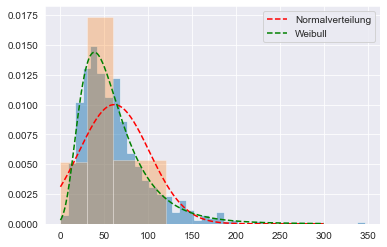

In [9]:
# Plotting
plt.plot(bins, y, 'r--', label='Normalverteilung')
# plt.plot(bins, y2, 'b.')
plt.plot(bins, y3, 'g--', label='Weibull')
plt.hist(r3,density=True, bins='auto', histtype='stepfilled', alpha=0.5)
plt.hist(parking_duration_sample, bins = [0, 30, 60, 120], density=True, alpha=0.3)

plt.legend()
plt.show()

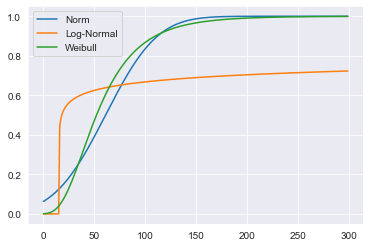

In [10]:
# CDF plotting
plt.plot(bins, stats.norm.cdf(bins, mu, sigma), label='Norm')
plt.plot(bins, stats.lognorm.cdf(bins, shape, loc=loc, scale=scale), label='Log-Normal')
plt.plot(bins, stats.exponweib.cdf(bins, a=a_out,c=Kappa_out,loc=loc_out,scale = Lambda_out), label='Weibull')

plt.legend()
plt.show()

## Conclusion
We have very limited data on the charging duration but can test in our simulation model a Weibull distribution for the duration with the following parameters
$$a=39.857766124920076$$
$$c=0.65117444343909$$
$$loc=-20.724236876543387$$
$$scale=8.472003942187907$$

Additional exception handling is needed if negative values are returned!

A charging duration for the next e-car can be computed with:

In [14]:
charge_time = stats.exponweib.rvs(a_out, Kappa_out, loc=loc_out, scale=Lambda_out, size=1)
print(charge_time)


[123.84897314]


With this returned numbers, we can run our simulation model and see the effect in the output

'VW_ID3_Pure' charged. Anzahl geladener EVs: 1
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 2
'VW_ID3_Pure' charged. Anzahl geladener EVs: 3
'VW_ID3_Pure' charged. Anzahl geladener EVs: 4
Alle Ladesäulen belegt. Abgewiesene EVs:  1
Alle Ladesäulen belegt. Abgewiesene EVs:  2
Alle Ladesäulen belegt. Abgewiesene EVs:  3
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 5
'VW_ID3_Pure' charged. Anzahl geladener EVs: 6
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 7
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 8
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 9
Alle Ladesäulen belegt. Abgewiesene EVs:  4
'VW_ID3_Pure' charged. Anzahl geladener EVs: 10
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 11
'VW_ID3_Pure' charged. Anzahl geladener EVs: 12
'VW_ID3_Pure' charged. Anzahl geladener EVs: 13
'VW_ID3_Pure' charged. Anzahl geladener EVs: 14
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 15
'VW_ID3_Pure' charged. Anzahl geladener EVs: 16
'Tesla_Model_3_LR' charged. An

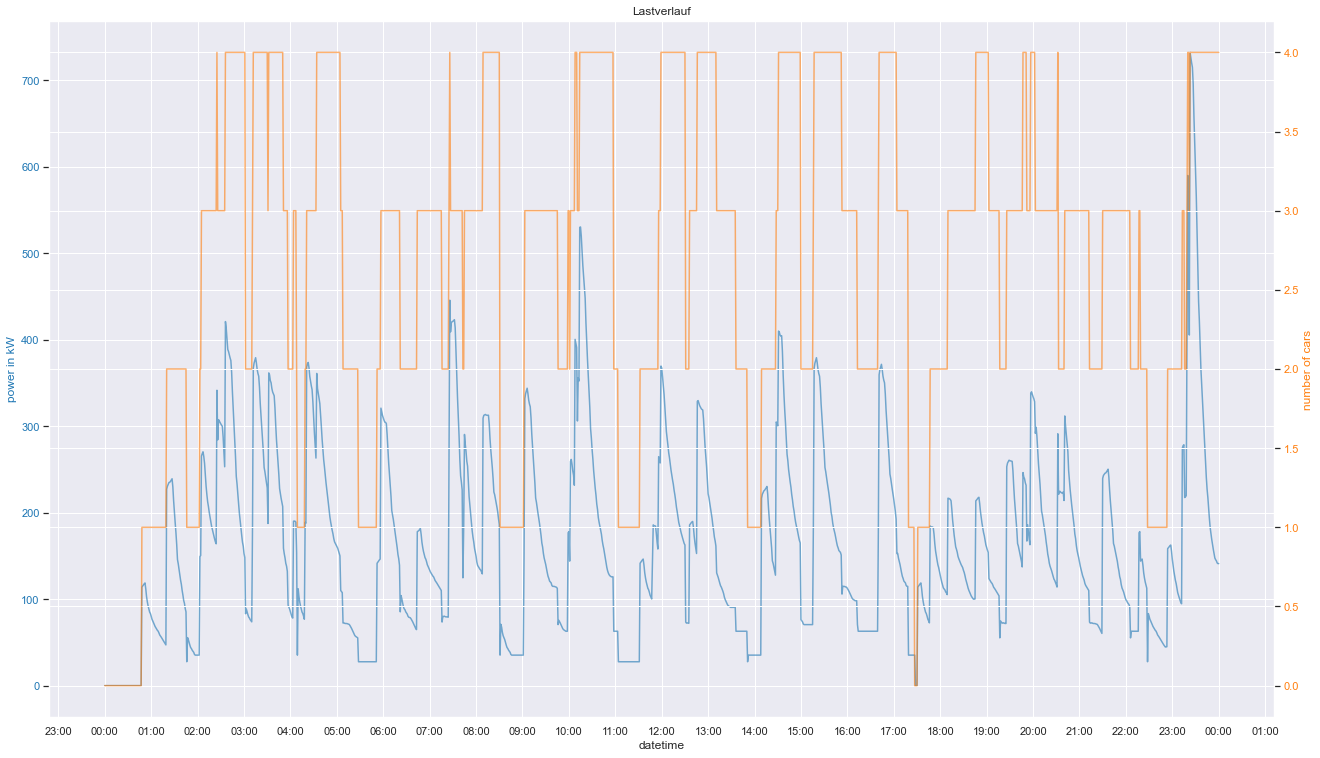

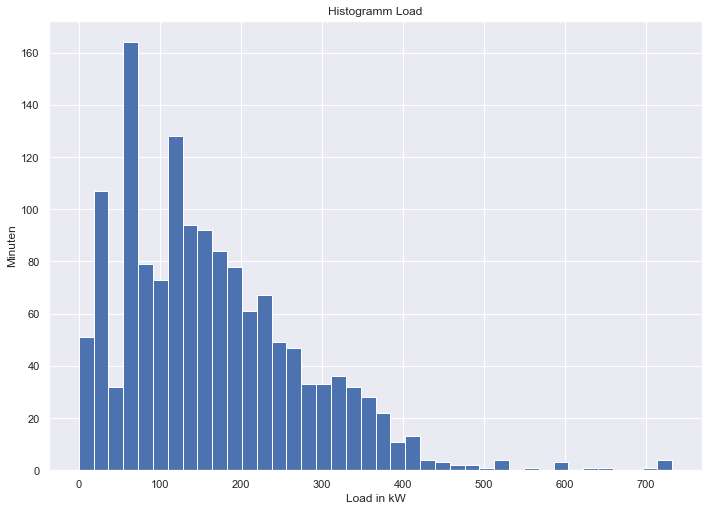

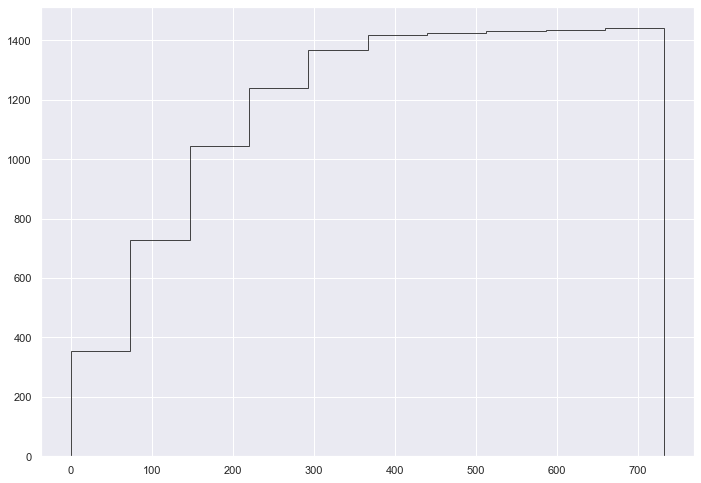

,power_per_minute,number_cars_charging
count,1441.000000,1441.000000
mean,165.550487,2.634282
std,112.890101,1.126162
min,0.000000,0.000000
25%,73.875822,2.000000
50%,145.413534,3.000000
75%,228.821798,4.000000
max,732.498250,4.000000


In [42]:
import importlib
# import random
import pandas as pd
# import matplotlib.dates as mdates
import json
import numpy as np
import matplotlib.pyplot as plt
import model_v2
importlib.reload(model_v2)

with open("settings_model_charging-time.json", "r") as f:
    settings = json.load(f)

df_results_returned = model_v2.simulation("settings_model_charging-time.json")
model_v2.plot(df_results_returned)
df_results_returned.describe()


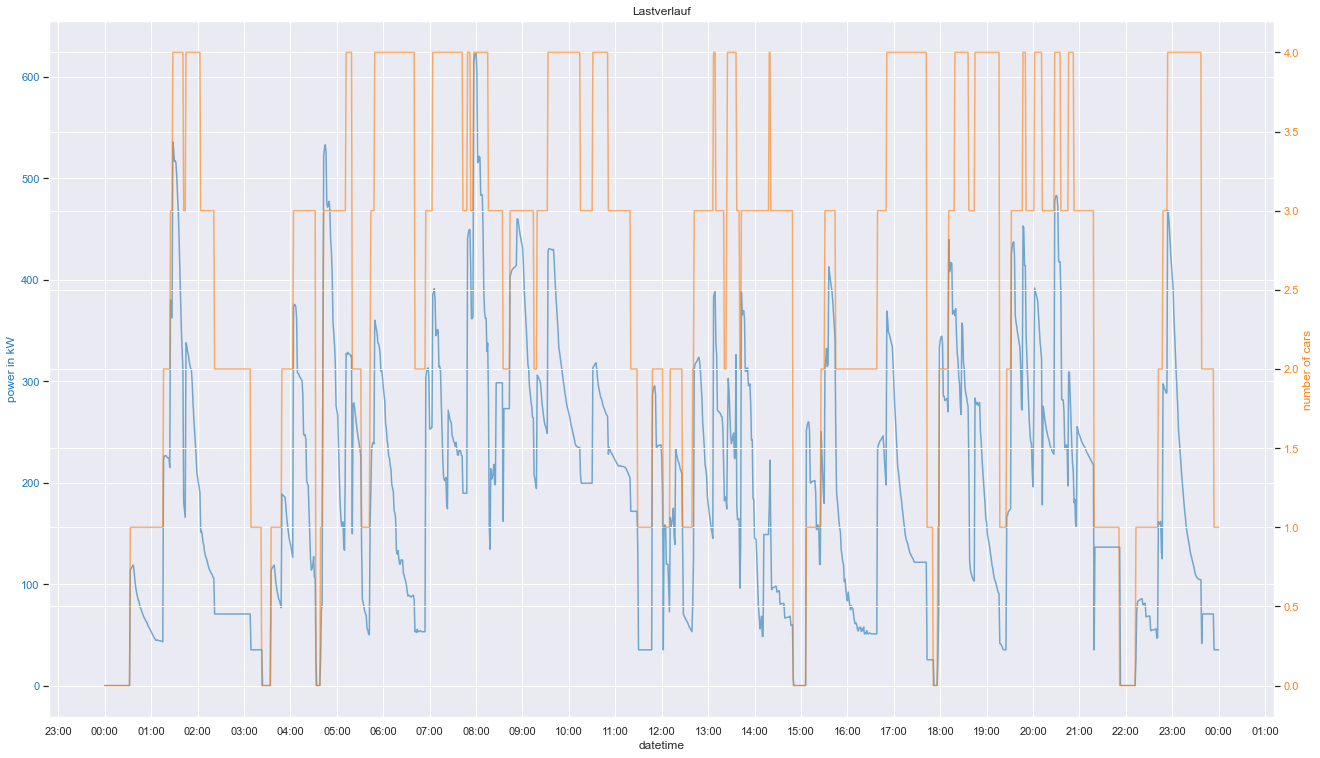

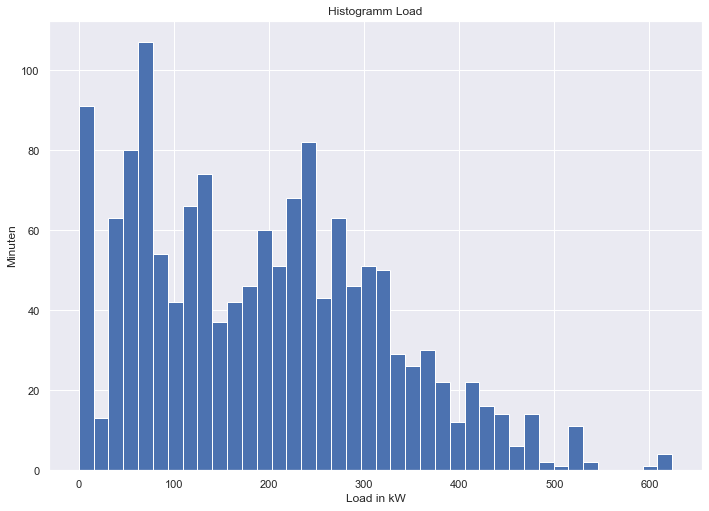

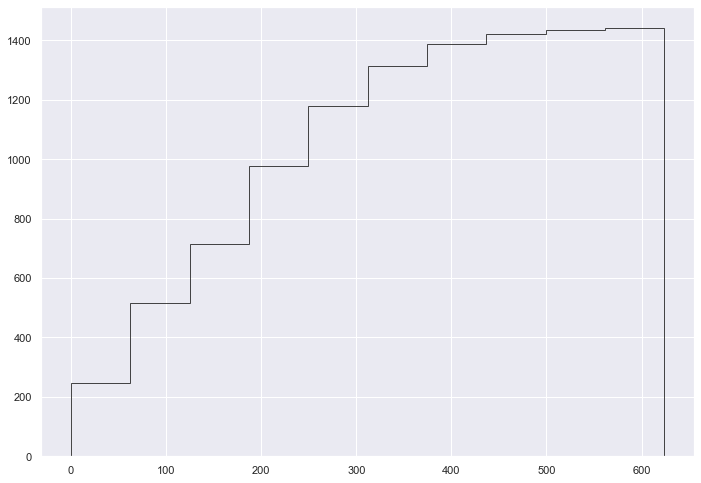

In [34]:
model_v2.plot(df_results_returned)

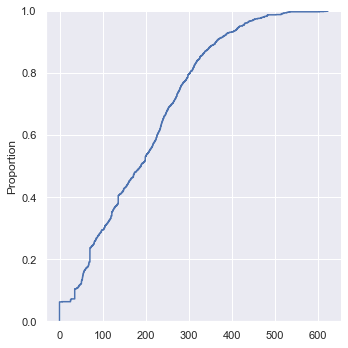

In [35]:
import seaborn as sns
sns.displot(np.asarray(df_results_returned['power_per_minute']), kind="ecdf")

## Mehrere Durchläuife

In folgendem Abschnitt wird die Simulation iterativ mehrere Male ausgeführt. Folglich kann ein gemittelter CDF-Plot zur Auswertung erstellt werden.

Zunächst wird die Parkdauer mit einem gleichverteiltem Zufallsgenerator generiert. Als Grenzen sind in den Einstellungen Werte zwischen 0 und 100 Minuten eingestellt.

In [3]:
import pandas as pd
import importlib
import model_v2
importlib.reload(model_v2)

df_results_10_runs = pd.DataFrame()
df_results_10_runs_single_row_rand = pd.DataFrame()
anzahl_evs_gesamt = 0
anzahl_evs_abgewiesen_gesamt = 0

for i in range(100):
    importlib.reload(model_v2)
    new_column_name = f'power_run_{i}'
    df_results_returned, anzahl_evs, anzahl_evs_abgewiesen = model_v2.simulation("settings_model_charging-time.json")
    df_results_10_runs[new_column_name] = df_results_returned.power_per_minute
    df_results_10_runs_single_row_rand = pd.concat([df_results_10_runs_single_row_rand, df_results_returned])
    anzahl_evs_gesamt = anzahl_evs_gesamt + anzahl_evs
    anzahl_evs_abgewiesen_gesamt = anzahl_evs_abgewiesen_gesamt + anzahl_evs_abgewiesen

print("Abgewiesene EVs gesamt: ", anzahl_evs_abgewiesen_gesamt)
print("Anzahl EVs gesamt: ", anzahl_evs_gesamt)

soc_begin:  gauss , [33.93558444]
soc_begin:  gauss , [13.37934046]
soc_begin:  gauss , [29.13282032]
'Hyundai_IONIQ5_LongRange' charged 48.22 kWh to 100.35 % SOC
soc_begin:  gauss , [23.78817912]
'Hyundai_IONIQ5_LongRange' charged 63.14 kWh to 100.35 % SOC
'2021_FIAT_500e_Hatchback' charged 26.92 kWh to 87.88 % SOC
soc_begin:  gauss , [37.19213921]
'2021_FIAT_500e_Hatchback' charged 29.39 kWh to 99.10 % SOC
'Porsche_Taycan' charged 50.44 kWh to 91.19 % SOC
soc_begin:  gauss , [39.57490892]
soc_begin:  gauss , [39.04905106]
soc_begin:  gauss , [9.38961194]
'Hyundai_KONA_64kWh' charged 38.06 kWh to 99.05 % SOC
'VW_ID3_Pure_45kWh' charged 35.64 kWh to 100.51 % SOC
'Tesla_Model_SX_LR' charged 82.43 kWh to 91.82 % SOC
soc_begin:  gauss , [36.55581297]
soc_begin:  gauss , [41.32817513]
soc_begin:  gauss , [25.95028043]
'Tesla_Model_SX_LR' charged 53.79 kWh to 90.34 % SOC
'Tesla_Model_SX_LR' charged 58.36 kWh to 84.31 % SOC
'Hyundai_KONA_64kWh' charged 37.60 kWh to 100.08 % SOC
soc_begin:  g

Nun wird die Simulation wiederholt, allerdings mit der Weibull-Verteilung und den oben bestimmten Parametern:

In [4]:
import pandas as pd
import importlib
import model_v2
importlib.reload(model_v2)

df_results_10_runs = pd.DataFrame()
df_results_10_runs_single_row_weibull = pd.DataFrame()
anzahl_evs_gesamt = 0
anzahl_evs_abgewiesen_gesamt = 0

for i in range(100):
    importlib.reload(model_v2)
    new_column_name = f'power_run_{i}'
    df_results_returned, anzahl_evs, anzahl_evs_abgewiesen = model_v2.simulation("settings_soc_begin.json")
    df_results_10_runs[new_column_name] = df_results_returned.power_per_minute
    df_results_10_runs_single_row_weibull = pd.concat([df_results_10_runs_single_row_weibull, df_results_returned])
    anzahl_evs_gesamt = anzahl_evs_gesamt + anzahl_evs
    anzahl_evs_abgewiesen_gesamt = anzahl_evs_abgewiesen_gesamt + anzahl_evs_abgewiesen

print("Abgewiesene EVs gesamt: ", anzahl_evs_abgewiesen_gesamt)
print("Anzahl EVs gesamt: ", anzahl_evs_gesamt)

soc_begin:  gauss , [17.30351929]
'VW_ID3_Pure_45kWh' charged 13.19 kWh to 40.04 % SOC
soc_begin:  gauss , [23.59641926]
soc_begin:  gauss , [26.11191138]
soc_begin:  gauss , [22.77801367]
soc_begin:  gauss , [28.65892718]
'Tesla_Model3_LR' charged 59.15 kWh to 97.81 % SOC
'2021_FIAT_500e_Hatchback' charged 30.99 kWh to 96.56 % SOC
'Hyundai_IONIQ5_LongRange' charged 52.01 kWh to 100.30 % SOC
'Tesla_ModelY' charged 62.71 kWh to 100.07 % SOC
soc_begin:  gauss , [33.14742611]
'Tesla_Model_SX_LR' charged 60.80 kWh to 93.95 % SOC
soc_begin:  gauss , [49.63794016]
soc_begin:  gauss , [20.47048244]
soc_begin:  gauss , [33.1600973]
soc_begin:  gauss , [21.73556739]
'Tesla_ModelY' charged 41.40 kWh to 100.12 % SOC
'Porsche_Taycan' charged 74.84 kWh to 100.60 % SOC
'Tesla_ModelY' charged 42.75 kWh to 73.87 % SOC
soc_begin:  gauss , [48.12314923]
soc_begin:  gauss , [33.16196885]
'Tesla_ModelY' charged 54.85 kWh to 100.04 % SOC
'Tesla_ModelY' charged 34.57 kWh to 90.28 % SOC
'Tesla_ModelY' charge

In [37]:
df_results_10_runs.describe()

,"(load_run, 0)","(load_run, 1)","(load_run, 2)","(load_run, 3)","(load_run, 4)","(load_run, 5)","(load_run, 6)","(load_run, 7)","(load_run, 8)","(load_run, 9)"
count,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000
mean,181.368284,175.583398,154.589019,181.173644,177.630455,151.373827,157.071226,168.914522,166.648777,166.493283
std,130.005446,135.809152,115.564892,115.011662,111.918915,125.386973,100.119335,101.955905,111.300452,123.165687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,76.794484,69.085290,67.561669,96.847135,109.305441,42.140315,88.001983,88.125009,70.918762,79.966365
50%,171.093262,154.866510,136.476868,164.341637,165.069865,126.302876,152.376486,166.069473,142.971128,140.012762
75%,262.879202,264.057658,204.449102,260.902160,249.437144,246.634444,209.514108,228.867714,239.454426,222.669039
max,659.474421,690.027503,666.792069,546.725928,552.452262,553.838384,546.169158,585.477820,504.159076,655.978648


Anschließend wird über die Durchläufe gemittelt der CDF geplottet

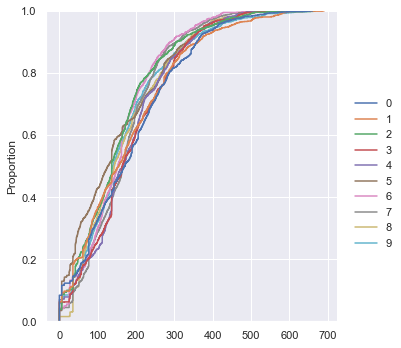

In [38]:
sns.displot(df_results_10_runs.values, kind="ecdf")

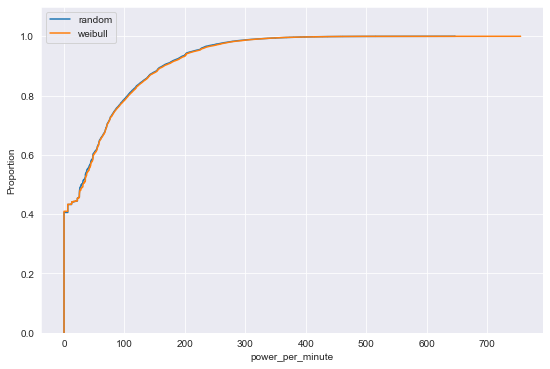

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 6))

sns.ecdfplot(data=df_results_10_runs_single_row_rand, x="power_per_minute", label="random")
sns.ecdfplot(data=df_results_10_runs_single_row_weibull, x="power_per_minute", label = "weibull")

plt.ylim(0, 1.1)
plt.legend()
plt.show()